In [4]:
from imutils import face_utils
import numpy as np
import imutils
import argparse
import dlib
import cv2
import random
from PIL import Image
# import the necessary packages
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib
import cv2

import matplotlib.pyplot as plt

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,help="path to facial landmark predictor")
#%tb ap.add_argument("-i", "--image", required=True,help="path to input image")
#%tb args = vars(ap.parse_args())



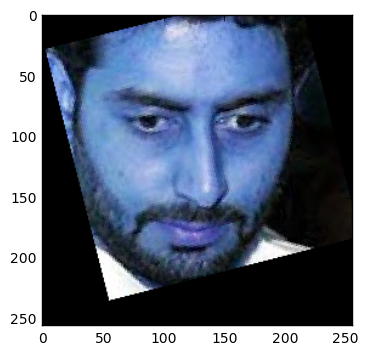

In [24]:
#%matplotlib inline
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=256)

# Face Align Function
def faceAlign(image):
    #image = cv2.imread(img)
    image = imutils.resize(image, width=800)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 2)
    faceAligned = []
    for rect in rects:
        faceAligned = fa.align(image, gray, rect)
        #print(rect)
        #plt.imshow(faceAligned)
    
    return faceAligned


image = cv2.imread('dataset_cropped/Denise Richards/DeniseRichards471.jpg')
#plt.imshow(image)
#plt.imshow(faceAlign(image))

image = faceAlign(image)


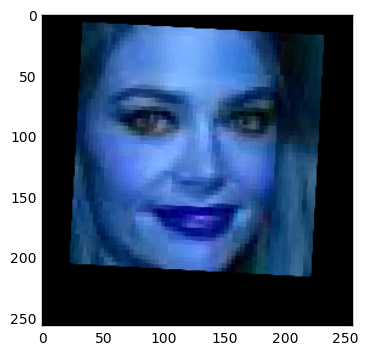

In [50]:
image = cv2.imread('dataset_cropped/Denise Richards/DeniseRichards471.jpg')
#plt.imshow(image)
#plt.imshow(faceAlign(image))

image = faceAlign(image)

plt.imshow(image)

In [7]:
import os                                                                                                             

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r  

image_paths=list_files('dataset_cropped')
#print(image_paths)

In [17]:
# Finding unique labesl and encoding them

all_labels = [imag.split('\\')[-2] for imag in image_paths]

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

In [18]:
unique_labels = list(le.classes_)
print(unique_labels)
print(le.transform(unique_labels))

['Abhishek Bachan', 'Alex Rodriguez', 'Ali Landry', 'Alyssa Milano', 'Anderson Cooper', 'Anna Paquin', 'Audrey Tautou', 'Barack Obama', 'Ben Stiller', 'Christina Ricci', 'Clive Owen', 'Cristiano Ronaldo', 'Daniel Craig', 'Danny Devito', 'David Duchovny', 'Denise Richards', 'Diane Sawyer']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [131]:
from tqdm import tqdm

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        try:
            image = faceAlign(cv2.imread(img_path));
        except:
            continue
        if image is not None and np.shape(np.shape(image)) == (3, ):
            images.append(image)
            labels.append(img_path.split('\\')[1])
    return images,labels

In [117]:
## Encoding labels


#list(le.classes_)

def data_gen(batch_size=30):
    while True:
        print('step1')
        image_paths=list_files('dataset_cropped')
        sample_dt=random.sample(image_paths,int(batch_size)+10)
        
        images,labels=read_images(sample_dt)
        #images,measurements=random_append_augment_images(images,measurements)
        print('step2')
        print(sample_dt)
        images=np.asarray(images)
        labels=np.asarray(labels)
        #print('images shape',images.shape)
        #print('measurements shape',measurements.shape)
        ind = np.random.choice(images.shape[0], batch_size, replace=False)
        images=images[ind,:,:,:]
        labels=le.transform(labels[ind])
        X=images
        y=labels
        print(np.shape(images))
        yield X,y

In [52]:
sample_length = 15
image_paths=list_files('dataset_cropped')
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

In [132]:
c,v = next(data_gen(10))

step1
step2
['dataset_cropped\\Clive Owen\\CliveOwen1221.jpg', 'dataset_cropped\\Cristiano Ronaldo\\CristianoRonaldo561.jpg', 'dataset_cropped\\Audrey Tautou\\AudreyTautou271.jpg', 'dataset_cropped\\Barack Obama\\BarackObama891.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny3521.jpg', 'dataset_cropped\\Alyssa Milano\\AlyssaMilano221.jpg', 'dataset_cropped\\Daniel Craig\\DanielCraig661.jpg', 'dataset_cropped\\Barack Obama\\BarackObama4251.jpg', 'dataset_cropped\\Denise Richards\\DeniseRichards2031.jpg', 'dataset_cropped\\Clive Owen\\CliveOwen601.jpg', 'dataset_cropped\\Alyssa Milano\\AlyssaMilano2781.jpg', 'dataset_cropped\\Ben Stiller\\BenStiller271.jpg', 'dataset_cropped\\Anna Paquin\\AnnaPaquin831.jpg', 'dataset_cropped\\Daniel Craig\\DanielCraig3901.jpg', 'dataset_cropped\\Daniel Craig\\DanielCraig1701.jpg', 'dataset_cropped\\Daniel Craig\\DanielCraig2801.jpg', 'dataset_cropped\\Alex Rodriguez\\AlexRodriguez831.jpg', 'dataset_cropped\\Denise Richards\\DeniseRichards431.jpg', '

In [136]:
# Alexnet

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model_base = Sequential()
model_base.add(Conv2D(32, 3, 3, input_shape=input_shape))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))

model_base.add(Conv2D(32, 3, 3))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))

model_base.add(Conv2D(64, 3, 3))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))


model_base.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_base.add(Dense(64))
model_base.add(Activation('relu'))
model_base.add(Dropout(0.5))
model_base.add(Dense(1))
model_base.add(Activation('sigmoid'))

model_base.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

gen_train=data_gen(15)
gen_valid=data_gen(15)


model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25, verbose =2)

step1Epoch 1/4

step2
['dataset_cropped\\Cristiano Ronaldo\\CristianoRonaldo1691.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny1391.jpg', 'dataset_cropped\\Christina Ricci\\ChristinaRicci821.jpg', 'dataset_cropped\\Audrey Tautou\\AudreyTautou1491.jpg', 'dataset_cropped\\Barack Obama\\BarackObama21.jpg', 'dataset_cropped\\Daniel Craig\\DanielCraig61.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny391.jpg', 'dataset_cropped\\Cristiano Ronaldo\\CristianoRonaldo2531.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny2061.jpg', 'dataset_cropped\\Christina Ricci\\ChristinaRicci2471.jpg', 'dataset_cropped\\Clive Owen\\CliveOwen1801.jpg', 'dataset_cropped\\Christina Ricci\\ChristinaRicci831.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny4001.jpg', 'dataset_cropped\\Cristiano Ronaldo\\CristianoRonaldo1381.jpg', 'dataset_cropped\\Alyssa Milano\\AlyssaMilano1521.jpg', 'dataset_cropped\\Cristiano Ronaldo\\CristianoRonaldo801.jpg', 'dataset_cropped\\Barack Obama\\BarackObama1451

KeyboardInterrupt: 

In [133]:
# Modified Alexnet

from keras.models import Sequential
from keras.layers import Flatten,Dense, Lambda
# There was a problem with original Keras progress bar due to which Notebook used to hang.
# Changing the progress bar with another version of it so as to get the code working in Notebook. Look at model.fit command on how its used
#from keras_tqdm import TQDMNotebookCallback 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D, ELU
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

input_shape=(image.shape[0],image.shape[1],3)
model=Sequential()
model.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
model.add(Conv2D(3,1,1,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(24,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(36,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Dropout(.4))
model.add(Conv2D(48,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(Dropout(.3))
model.add(ELU())
model.add(Flatten())
model.add(Dense(1164,init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(1,init='he_normal'))

model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(15)
gen_valid=data_gen(15)


In [134]:
model.fit_generator(gen_train, samples_per_epoch=2500,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25, verbose =2)

Epoch 1/4step1

step2
['dataset_cropped\\David Duchovny\\DavidDuchovny2091.jpg', 'dataset_cropped\\Clive Owen\\CliveOwen2331.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny3861.jpg', 'dataset_cropped\\Audrey Tautou\\AudreyTautou581.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny1261.jpg', 'dataset_cropped\\Barack Obama\\BarackObama211.jpg', 'dataset_cropped\\Alyssa Milano\\AlyssaMilano1751.jpg', 'dataset_cropped\\Alyssa Milano\\AlyssaMilano71.jpg', 'dataset_cropped\\Barack Obama\\BarackObama4841.jpg', 'dataset_cropped\\Barack Obama\\BarackObama581.jpg', 'dataset_cropped\\Christina Ricci\\ChristinaRicci2071.jpg', 'dataset_cropped\\David Duchovny\\DavidDuchovny3491.jpg', 'dataset_cropped\\Anna Paquin\\AnnaPaquin561.jpg', 'dataset_cropped\\Alyssa Milano\\AlyssaMilano1381.jpg', 'dataset_cropped\\Barack Obama\\BarackObama4021.jpg', 'dataset_cropped\\Barack Obama\\BarackObama3091.jpg', 'dataset_cropped\\Anna Paquin\\AnnaPaquin1301.jpg', 'dataset_cropped\\Denise Richards\\DeniseRi

KeyboardInterrupt: 